In [57]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [58]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [59]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [60]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [61]:
tf.keras.backend.clear_session()

In [62]:
subject = 'Distrito Federal - Consumo de Cimento (t)'
start_index = 0
split_index = 203
window_size = 36
train_split = split_index + 1 - 12

In [63]:
data = pd.read_csv('2003_mo_model_input_DF.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Distrito Federal - value,Distrito Federal - Depósito Poupança (R$),Distrito Federal - Desemprego,Distrito Federal - IDH Educacao,Distrito Federal- custo m2 (R$),Distrito Federal - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Distrito Federal - IDH,Distrito Federal - IDH Renda,Distrito Federal - Consumo de Cimento (t),Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - PIB - Per Capita,Distrito Federal - PIB - Preços de Mercado,Distrito Federal - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.254227,4.896482e+06,8.293882,0.785137,12173.796800,0.835563,2.290151,887.301063,1472.275657,22.112973,15.990623,71.130346,2.506073,0.826971,0.871928,50.047,1.184017e+08,3.570616e+06,43.639430,1.092465e+08,156.625720,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.252655,4.934178e+06,8.287887,0.785313,12272.096031,0.835922,2.170793,887.625500,1467.038600,21.790128,15.663933,70.741484,2.494967,0.827063,0.871678,48.110,1.185511e+08,3.573184e+06,43.651300,1.093025e+08,157.678528,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.250972,4.971875e+06,8.281892,0.785489,12362.351216,0.836281,1.843974,887.995527,1443.186660,21.382001,14.859800,69.073150,2.482659,0.827155,0.871428,49.006,1.187006e+08,3.575752e+06,43.663170,1.093585e+08,159.190268,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.249179,5.009571e+06,8.275896,0.785664,12449.345859,0.836640,1.842883,888.753058,1484.414910,20.864040,13.463843,65.515153,2.541473,0.827247,0.871178,48.445,1.188500e+08,3.578320e+06,43.675041,1.094145e+08,160.688376,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.247070,5.047268e+06,8.269901,0.785840,12543.454480,0.836999,1.498497,889.051690,1487.564625,20.593129,12.206035,61.816227,2.562082,0.827340,0.870928,51.436,1.189994e+08,3.580889e+06,43.686911,1.094705e+08,162.847410,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2002-8,NaN,NaN,NaN,NaN,NaN,NaN,2.285520,888.063858,1554.000510,22.107259,11.557766,54.920321,2.663202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,2002-9,NaN,NaN,NaN,NaN,NaN,NaN,2.459765,887.482239,1504.599147,22.342946,12.632697,58.260143,2.597288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,2002-10,NaN,NaN,NaN,NaN,NaN,NaN,2.404292,887.089138,1477.730987,22.495195,13.705746,61.921603,2.551755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,2002-11,NaN,NaN,NaN,NaN,NaN,NaN,2.375765,887.036669,1469.367571,22.206488,14.859807,66.774435,2.510615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


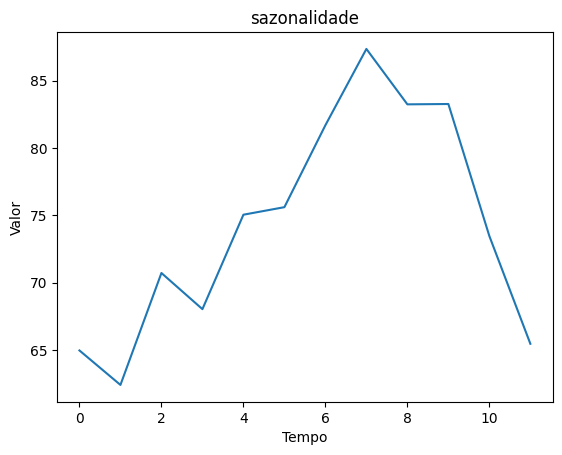

,sazonalidade
sazonalidade,
0,64.951290
1,62.390638
2,70.707701
3,68.022304
4,75.039967
5,75.600243
6,81.690452
7,87.360300
8,83.241836


In [64]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [65]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Distrito Federal - value,Distrito Federal - Depósito Poupança (R$),Distrito Federal - Desemprego,Distrito Federal - IDH Educacao,Distrito Federal- custo m2 (R$),Distrito Federal - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Distrito Federal - IDH,Distrito Federal - IDH Renda,Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - PIB - Per Capita,Distrito Federal - PIB - Preços de Mercado,Distrito Federal - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Distrito Federal - Consumo de Cimento (t)
0,2003-1,0.254227,4.896482e+06,8.293882,0.785137,12173.796800,0.835563,2.290151,887.301063,1472.275657,22.112973,15.990623,71.130346,2.506073,0.826971,0.871928,1.184017e+08,3.570616e+06,43.639430,1.092465e+08,156.625720,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,64.951290,50.047
1,2003-2,0.252655,4.934178e+06,8.287887,0.785313,12272.096031,0.835922,2.170793,887.625500,1467.038600,21.790128,15.663933,70.741484,2.494967,0.827063,0.871678,1.185511e+08,3.573184e+06,43.651300,1.093025e+08,157.678528,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,62.390638,48.110
2,2003-3,0.250972,4.971875e+06,8.281892,0.785489,12362.351216,0.836281,1.843974,887.995527,1443.186660,21.382001,14.859800,69.073150,2.482659,0.827155,0.871428,1.187006e+08,3.575752e+06,43.663170,1.093585e+08,159.190268,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,70.707701,49.006
3,2003-4,0.249179,5.009571e+06,8.275896,0.785664,12449.345859,0.836640,1.842883,888.753058,1484.414910,20.864040,13.463843,65.515153,2.541473,0.827247,0.871178,1.188500e+08,3.578320e+06,43.675041,1.094145e+08,160.688376,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,68.022304,48.445
4,2003-5,0.247070,5.047268e+06,8.269901,0.785840,12543.454480,0.836999,1.498497,889.051690,1487.564625,20.593129,12.206035,61.816227,2.562082,0.827340,0.870928,1.189994e+08,3.580889e+06,43.686911,1.094705e+08,162.847410,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,75.039967,51.436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2002-8,NaN,NaN,NaN,NaN,NaN,NaN,2.285520,888.063858,1554.000510,22.107259,11.557766,54.920321,2.663202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.039967,NaN
269,2002-9,NaN,NaN,NaN,NaN,NaN,NaN,2.459765,887.482239,1504.599147,22.342946,12.632697,58.260143,2.597288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.600243,NaN
270,2002-10,NaN,NaN,NaN,NaN,NaN,NaN,2.404292,887.089138,1477.730987,22.495195,13.705746,61.921603,2.551755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.690452,NaN
271,2002-11,NaN,NaN,NaN,NaN,NaN,NaN,2.375765,887.036669,1469.367571,22.206488,14.859807,66.774435,2.510615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [66]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      62.294
1      55.247
2      65.908
3      67.387
4      68.730
        ...  
268       NaN
269       NaN
270       NaN
271       NaN
272       NaN
Name: Distrito Federal - Consumo de Cimento (t), Length: 273, dtype: float64

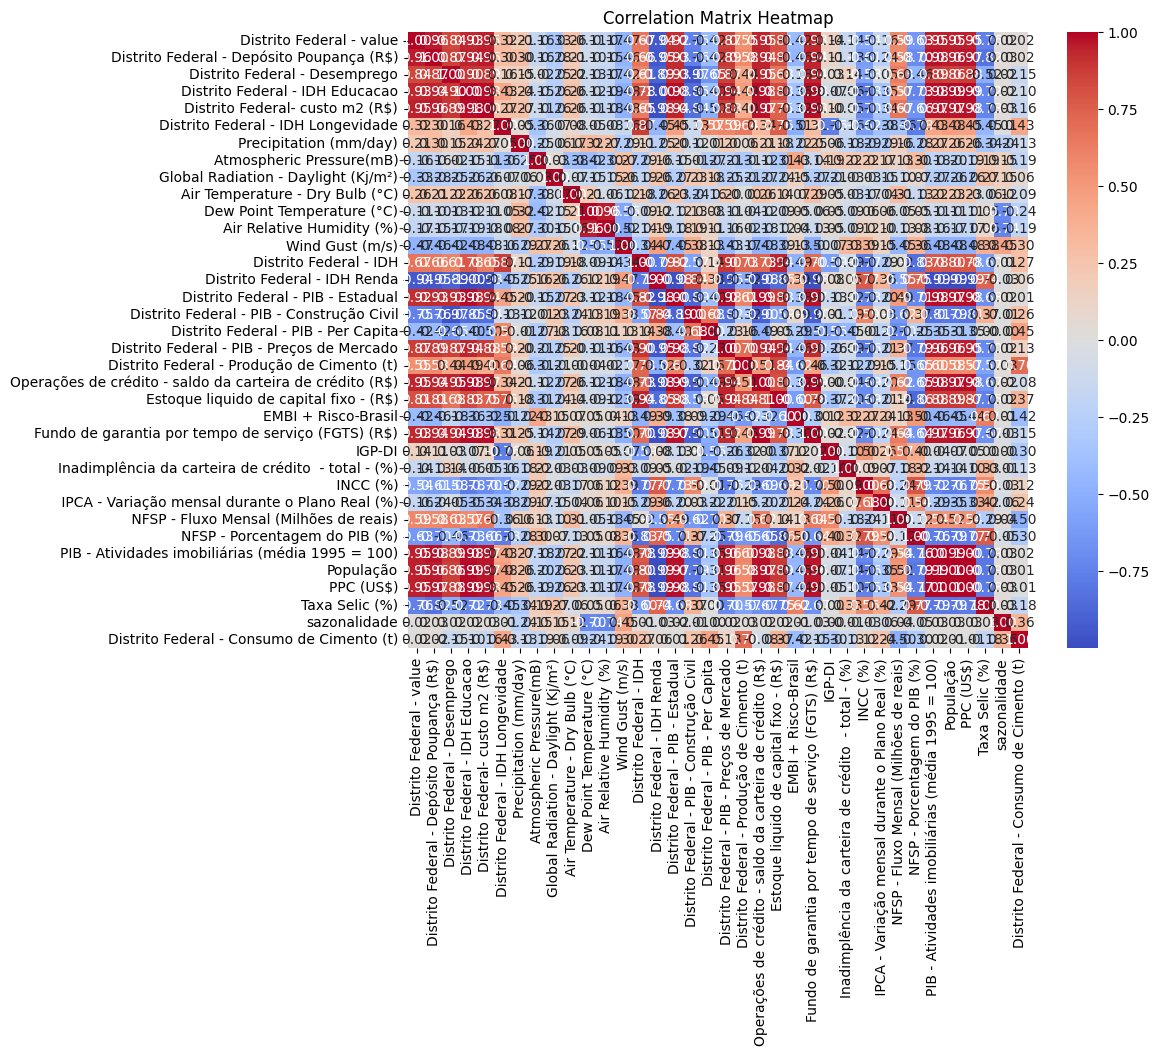

In [67]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [68]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [69]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Distrito Federal - value,2.562853e+03
1,Distrito Federal - Depósito Poupança (R$),3.318093e+03
2,Distrito Federal - Desemprego,9.736755e+02
3,Distrito Federal - IDH Educacao,3.746641e+08
4,Distrito Federal- custo m2 (R$),1.052235e+05
5,Distrito Federal - IDH Longevidade,3.368776e+03
6,Precipitation (mm/day),2.321557e+00
7,Atmospheric Pressure(mB),5.244859e+00
8,Global Radiation - Daylight (Kj/m²),3.101590e+00
9,Air Temperature - Dry Bulb (°C),2.843838e+01


In [70]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 3


,Distrito Federal - value,Distrito Federal - Depósito Poupança (R$),Distrito Federal - Desemprego,Distrito Federal - IDH Educacao,Distrito Federal- custo m2 (R$),Distrito Federal - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Distrito Federal - IDH Renda,Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,0.254227,4.896482e+06,8.293882,0.785137,12173.796800,0.835563,2.290151,887.301063,1472.275657,22.112973,15.990623,71.130346,2.506073,0.871928,1.184017e+08,3.570616e+06,156.625720,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,64.951290
1,0.252655,4.934178e+06,8.287887,0.785313,12272.096031,0.835922,2.170793,887.625500,1467.038600,21.790128,15.663933,70.741484,2.494967,0.871678,1.185511e+08,3.573184e+06,157.678528,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,62.390638
2,0.250972,4.971875e+06,8.281892,0.785489,12362.351216,0.836281,1.843974,887.995527,1443.186660,21.382001,14.859800,69.073150,2.482659,0.871428,1.187006e+08,3.575752e+06,159.190268,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,70.707701
3,0.249179,5.009571e+06,8.275896,0.785664,12449.345859,0.836640,1.842883,888.753058,1484.414910,20.864040,13.463843,65.515153,2.541473,0.871178,1.188500e+08,3.578320e+06,160.688376,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,68.022304
4,0.247070,5.047268e+06,8.269901,0.785840,12543.454480,0.836999,1.498497,889.051690,1487.564625,20.593129,12.206035,61.816227,2.562082,0.870928,1.189994e+08,3.580889e+06,162.847410,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,75.039967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,0.386162,1.435592e+07,11.972655,0.813522,29586.351424,0.842032,2.353125,888.212205,1555.317484,22.409402,11.396905,54.695265,2.366183,0.835086,1.390323e+08,3.488255e+06,230.298349,3.339533e+06,7.711687e+06,256.861070,1.038665e+07,1.139835,3.035443,0.628071,0.411247,6518.883661,1.836884,207.092470,2.005841e+08,437.906135,0.516394,87.360300
200,0.390476,1.459348e+07,11.965369,0.813317,29795.760704,0.841644,2.121232,887.401399,1546.996483,22.794351,12.375166,57.144711,2.303426,0.835079,1.388599e+08,3.490597e+06,230.674628,3.365687e+06,7.707969e+06,257.536049,1.036684e+07,1.152658,3.032326,0.635009,0.433581,6534.198970,1.814025,207.285636,2.006695e+08,438.554287,0.509923,83.241836
201,0.395678,1.483104e+07,11.958082,0.813112,30016.701372,0.841255,2.335512,886.807169,1510.476374,22.689210,13.904031,62.517611,2.255571,0.835073,1.386875e+08,3.492940e+06,232.861087,3.396904e+06,7.704251e+06,259.995111,1.094126e+07,1.188899,3.007554,0.648424,0.461431,6135.626515,1.810325,207.478801,2.007550e+08,439.156241,0.467083,83.266697
202,0.401222,1.506860e+07,11.950795,0.812907,30258.583835,0.840867,2.498041,886.610949,1467.734578,22.448525,15.162955,67.812435,2.19412

In [71]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Distrito Federal - Depósito Poupança (R$),Distrito Federal - Desemprego,Distrito Federal - IDH Educacao,Distrito Federal- custo m2 (R$),Distrito Federal - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Distrito Federal - IDH Renda,Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,-1.609388,-0.891709,-1.801086,-1.503168,-2.920605,0.201786,-0.132081,-0.272675,1.108521,1.176674,0.814036,0.588729,1.874605,-1.757548,0.447408,-1.964117,-1.405679,-2.469876,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-2.064648,-1.851489,2.125141
1,-1.595015,-0.894942,-1.782156,-1.484012,-2.839109,-0.156007,0.061603,-0.277163,0.570032,1.000054,0.754765,0.529280,1.852942,-1.738619,0.482800,-1.940052,-1.405133,-2.431875,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-2.037913,-1.840236,1.610904
2,-1.580643,-0.898176,-1.763227,-1.466423,-2.757612,-1.135689,0.282503,-0.297605,-0.110707,0.565310,0.500475,0.463392,1.831278,-1.719690,0.518192,-1.905498,-1.405096,-2.393874,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-2.011179,-1.828623,2.950828
3,-1.566271,-0.901409,-1.744298,-1.449469,-2.676116,-1.138959,0.734737,-0.262271,-0.974642,-0.189396,-0.041841,0.778229,1.809615,-1.700761,0.553584,-1.871255,-1.404678,-2.355872,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.984445,-1.816740,1.307354
4,-1.551899,-0.904643,-1.725369,-1.431130,-2.594620,-2.171302,0.913016,-0.259572,-1.426508,-0.869412,-0.605637,0.888550,1.787952,-1.681831,0.588976,-1.821906,-1.403356,-2.317871,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.957710,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,1.997137,1.092358,1.257421,1.890190,-1.452415,0.390559,0.411857,-0.201506,1.602951,-1.306858,-1.691026,-0.160109,-1.317942,0.856234,-0.687589,-0.280161,1.360064,0.117681,-0.334258,1.332879,3.148408,-0.736097,0.370628,-0.689886,2.909383,-0.724085,1.428371,1.378950,1.402207,-1.370268
200,2.087710,1.088428,1.235345,1.931000,-1.540532,-0.304570,-0.072181,-0.208637,2.245030,-0.777974,-1.317677,-0.496053,-1.318512,0.834392,-0.655308,-0.271560,1.384545,0.092456,-0.327663,1.326386,3.219670,-0.746418,0.427775,-0.441954,2.913017,-0.736434,1.436331,1.391539,1.410056,-1.390925
201,2.178283,1.084498,1.213269,1.974057,-1.628650,0.337760,-0.426927,-0.239936,2.069660,0.048586,-0.498731,-0.752222,-1.319082,0.812550,-0.623027,-0.221583,1.413764,0.067231,-0.303635,1.514665,3.421082,-0.828457,0.538287,-0.132782,2.818435,-0.738433,1.444292,1.404128,1.417346,-1.527663
202,2.268856,1.080568,1.191193,2.021195,-1.716767,0.824963,-0.544067,-0.276567,1.668208,0.729207,0.308315,-1.081154,-1.319652,0.790707,-0.590746,-0.200331,1.440408,0.042006,-0.275803,1.747673,3.373840,-0.866800,0.666156,0.084061,2.905726,-0.738236,1.456774,1.416717,1.423988,-1.609340


In [72]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Distrito Federal - Depósito Poupança (R$),Distrito Federal - Desemprego,Distrito Federal - IDH Educacao,Distrito Federal- custo m2 (R$),Distrito Federal - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Distrito Federal - IDH Renda,Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,-1.609388,-0.891709,-1.801086,-1.503168,-2.920605,0.201786,-0.132081,-0.272675,1.108521,1.176674,0.814036,0.588729,1.874605,-1.757548,0.447408,-1.964117,-1.405679,-2.469876,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-2.064648,-1.851489,2.125141
1,-1.595015,-0.894942,-1.782156,-1.484012,-2.839109,-0.156007,0.061603,-0.277163,0.570032,1.000054,0.754765,0.529280,1.852942,-1.738619,0.482800,-1.940052,-1.405133,-2.431875,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-2.037913,-1.840236,1.610904
2,-1.580643,-0.898176,-1.763227,-1.466423,-2.757612,-1.135689,0.282503,-0.297605,-0.110707,0.565310,0.500475,0.463392,1.831278,-1.719690,0.518192,-1.905498,-1.405096,-2.393874,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-2.011179,-1.828623,2.950828
3,-1.566271,-0.901409,-1.744298,-1.449469,-2.676116,-1.138959,0.734737,-0.262271,-0.974642,-0.189396,-0.041841,0.778229,1.809615,-1.700761,0.553584,-1.871255,-1.404678,-2.355872,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.984445,-1.816740,1.307354
4,-1.551899,-0.904643,-1.725369,-1.431130,-2.594620,-2.171302,0.913016,-0.259572,-1.426508,-0.869412,-0.605637,0.888550,1.787952,-1.681831,0.588976,-1.821906,-1.403356,-2.317871,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.957710,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.257076,1.118806,1.385928,1.525611,-0.463245,-0.123692,0.136570,-0.271671,0.292393,-0.782396,-0.878583,-1.098834,-1.293286,1.065983,-1.039663,-0.505827,1.193119,0.391058,-0.234432,1.098595,0.237913,-0.637894,-1.790206,-1.972576,2.018327,-0.537386,1.267871,1.238976,1.279826,-1.152820
188,1.278286,1.119018,1.391133,1.547464,-0.537715,0.846378,-0.195007,-0.281935,0.611066,-0.273789,-0.427487,-1.207309,-1.297420,1.054613,-1.014442,-0.494276,1.206925,0.371698,-0.187714,1.076314,0.559735,-0.723145,-1.629944,-1.832285,2.313396,-0.553461,1.288480,1.249345,1.291262,-1.253503
189,1.299497,1.119230,1.396338,1.570235,-0.612185,0.804228,-0.236644,-0.279434,0.759542,0.359638,0.119153,-1.233915,-1.301553,1.043242,-0.989221,-0.484881,1.227934,0.352338,-0.161779,1.263463,0.802696,-0.863773,-1.383366,-1.767518,2.353157,-0.577640,1.309088,1.259715,1.301919,-1.425444
190,1.320707,1.119443,1.401543,1.593154,-0.686655,0.225951,-0.296032,-0.270308,0.709664,0.712964,0.518310,-1.332648,-1.305686,1.031872,-0.964000,-0.474422,1.246115,0.332977,-0.157728,1.498990,1.106124,-0.975183,-1.227161,-1.688436,2.550824,-0.606406,1.322965,1.270085,1.311660,-1.237935


In [73]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      62.294
1      55.247
2      65.908
3      67.387
4      68.730
        ...  
187    67.615
188    62.302
189    66.663
190    58.228
191    52.525
Name: Distrito Federal - Consumo de Cimento (t), Length: 192, dtype: float64

In [74]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [75]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(156, 36, 30)

In [76]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Distrito Federal - Depósito Poupança (R$),Distrito Federal - Desemprego,Distrito Federal - IDH Educacao,Distrito Federal- custo m2 (R$),Distrito Federal - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Distrito Federal - IDH Renda,Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
156,0.343795,1.235892,1.274921,0.861931,1.407466,-0.263742,-0.323614,-0.226719,1.971767,0.987510,0.456096,-0.738052,-1.180825,1.184451,-1.475149,0.214500,1.222613,0.845472,0.893819,1.318837,-0.878779,0.613775,-0.843949,0.077835,0.557789,-0.555830,0.827975,0.903734,0.911463,0.407265
157,0.372159,1.229009,1.268133,0.881546,1.356974,-0.882553,0.031334,-0.177609,1.981701,0.716234,0.044345,-1.074757,-1.187608,1.185636,-1.480167,0.154759,1.211968,0.833972,1.005776,1.195627,-1.051645,0.807648,-0.905729,-0.168265,0.729389,-0.572666,0.830073,0.914718,0.922870,0.137084
158,0.400523,1.222125,1.261345,0.901045,1.306482,-1.232086,0.375352,-0.213978,1.228033,0.274043,-0.217222,-0.894271,-1.194390,1.186820,-1.485184,0.099721,1.202030,0.822472,1.076752,1.159056,-1.098564,1.037275,-0.974248,-0.389950,0.683989,-0.585674,0.832171,0.925702,0.935360,0.296087
159,0.428887,1.215242,1.254557,0.920837,1.255990,-1.582205,0.649265,-0.200533,0.629344,-0.492155,-0.847723,-0.679990,-1.201173,1.188004,-1.490202,0.053120,1.192181,0.810972,1.085553,1.111178,-1.062721,1.108728,-1.053570,-0.479719,0.610357,-0.596842,0.834269,0.936687,0.948135,0.197300
160,0.457252,1.208358,1.247769,0.940983,1.205498,-1.717000,0.907335,-0.212872,0.148870,-1.070670,-1.281294,-0.566378,-1.207956,1.189188,-1.495220,-0.013213,1.183708,0.799472,1.062918,1.101433,-0.935050,1.109333,-1.130350,-0.570527,0.678235,-0.605761,0.833606,0.947671,0.961143,0.469403
161,0.485616,1.201475,1.240980,0.961947,1.155005,-0.272282,0.924921,-0.201249,0.384254,-1.571247,-1.810105,-0.139742,-1.214739,1.190372,-1.500238,-0.039672,1.174004,0.787972,1.000960,1.094619,-0.911738,1.064134,-1.002475,-0.507950,0.656325,-0.615263,0.832943,0.958655,0.973478,0.775434
162,0.513980,1.194591,1.234192,0.983653,1.104513,0.727443,0.637428,-0.189306,1.017962,-1.552655,-1.970347,-0.029505,-1.221521,1.191557,-1.505255,-0.070288,1.166949,0.776472,0.914197,1.070145,-1.067437,1.167813,-1.242922,-0.557480,0.601603,-0.618938,0.832280,0.969639,0.985778,0.136553
163,0.542344,1.187707,1.227404,1.005617,1.054021,1.834050,0.261260,-0.232510,1.298776,-1.045993,-1.514130,0.026521,-1.228304,1.192741,-1.510273,-0.088056,1.159632,0.764972,0.810555,1.060594,-0.970725,1.364965,-1.322806,-0.742853,0.615006,-0.619453,0.840249,0.980624,0.999021,0.642038
164,0.570708,1.180824,1.220616,1.028270,1.003529,2.610117,-0.081774,-0.241207,1.522426,-0.502703,-1.029778,0.117182,-1.235087,1.193925,-1.515291,-0.100932,1.154709,0.753473,0.652883,1.041994,-0.841670,1.531106,-1.355523,-0.787367,0.546355,-0.611176,0.848219,0.991608,1.012408,0.482412
165,0.599073,1.173940,1.213828,1.051163,0.953037,0.896781,-0.363197,-0.260588,1.343454,0.120184,-0.371046,-0.317609,-1.241870,1.195109,-1.520308,-0.117888,1.151483,0.741973,0.494053,1.195016,-0.838453,1.617011,-1.376175,-0.757940,0.421319,-0.599627,0.856189,1.002592,1.025524,0.367764


In [77]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 30)

In [78]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [79]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(108, activation='tanh', 
                             kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [80]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [81]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1535050671, 2014719703, 3017366394, 3544181669, 3990491223, 468022203, 2113469569, 627275564, 1846852101, 2104005233]


Step: 0 ___________________________________________
val_loss: 64.87903594970703
winner_seed: 1535050671


Step: 1 ___________________________________________
val_loss: 28.306011199951172
winner_seed: 2014719703


Step: 2 ___________________________________________
val_loss: 80.76800537109375


Step: 3 ___________________________________________
val_loss: 57.291748046875


Step: 4 ___________________________________________
val_loss: 61.719356536865234


Step: 5 ___________________________________________
val_loss: 66.06632232666016


Step: 6 ___________________________________________
val_loss: 64.63294982910156


Step: 7 ___________________________________________
val_loss: 106.79938507080078


Step: 8 ___________________________________________
val_loss: 59.509517669677734


Step: 9 ___________________________________________
val_loss: 78.67484283447266


final_see

In [82]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 3105829098

Epoch 1/10000
5/5 [==============================] - 2s 92ms/step - loss: 4271.4800 - val_loss: 544.3126
Epoch 2/10000
5/5 [==============================] - 0s 8ms/step - loss: 578.5406 - val_loss: 396.8261
Epoch 3/10000
5/5 [==============================] - 0s 9ms/step - loss: 412.6741 - val_loss: 313.3857
Epoch 4/10000
5/5 [==============================] - 0s 7ms/step - loss: 3492.3171 - val_loss: 98.5357
Epoch 5/10000
5/5 [==============================] - 0s 8ms/step - loss: 512.2920 - val_loss: 120.1891
Epoch 6/10000
5/5 [==============================] - 0s 7ms/step - loss: 348.0117 - val_loss: 130.7878
Epoch 7/10000
5/5 [==============================] - 0s 7ms/step - loss: 208.3778 - val_loss: 103.7812
Epoch 8/10000
5/5 [==============================] - 0s 7ms/step - loss: 246.2820 - val_loss: 80.5249
Epoch 9/10000
5/5 [==============================] - 0s 8ms/step - loss: 193.9111 - val_loss: 84.5046
Epoch 10/10000
5/5 [==============================] - 0s 8ms/step - loss:

5/5 [==============================] - 0s 8ms/step - loss: 37.6995 - val_loss: 57.4402
Epoch 81/10000
5/5 [==============================] - 0s 8ms/step - loss: 30.6640 - val_loss: 76.1763
Epoch 82/10000
5/5 [==============================] - 0s 8ms/step - loss: 49.2214 - val_loss: 78.0607
Epoch 83/10000
5/5 [==============================] - 0s 8ms/step - loss: 33.8383 - val_loss: 32.7333
Epoch 84/10000
5/5 [==============================] - 0s 8ms/step - loss: 40.4984 - val_loss: 53.8701
Epoch 85/10000
5/5 [==============================] - 0s 7ms/step - loss: 33.8683 - val_loss: 60.0127
Epoch 86/10000
5/5 [==============================] - 0s 7ms/step - loss: 38.0749 - val_loss: 113.1295
Epoch 87/10000
5/5 [==============================] - 0s 7ms/step - loss: 48.2072 - val_loss: 82.1730
Epoch 88/10000
5/5 [==============================] - 0s 8ms/step - loss: 30.1097 - val_loss: 48.5660
Epoch 89/10000
5/5 [==============================] - 0s 8ms/step - loss: 35.0661 - val_loss: 46

5/5 [==============================] - 0s 8ms/step - loss: 42.6059 - val_loss: 91.4076
Epoch 160/10000
5/5 [==============================] - 0s 7ms/step - loss: 28.0343 - val_loss: 67.6429
Epoch 161/10000
5/5 [==============================] - 0s 7ms/step - loss: 26.5839 - val_loss: 80.4854
Epoch 162/10000
5/5 [==============================] - 0s 7ms/step - loss: 26.1879 - val_loss: 60.2332
Epoch 163/10000
5/5 [==============================] - 0s 8ms/step - loss: 28.4195 - val_loss: 90.9335
Epoch 164/10000
5/5 [==============================] - 0s 7ms/step - loss: 26.7345 - val_loss: 45.9534
Epoch 165/10000
5/5 [==============================] - 0s 8ms/step - loss: 30.6428 - val_loss: 73.5073
Epoch 166/10000
5/5 [==============================] - 0s 8ms/step - loss: 24.4827 - val_loss: 78.9165
Epoch 167/10000
5/5 [==============================] - 0s 7ms/step - loss: 23.3007 - val_loss: 117.9105
Epoch 168/10000
5/5 [==============================] - 0s 7ms/step - loss: 26.6604 - val

5/5 [==============================] - 0s 8ms/step - loss: 21.0067 - val_loss: 73.6679
Epoch 239/10000
5/5 [==============================] - 0s 8ms/step - loss: 24.1692 - val_loss: 74.6267
Epoch 240/10000
5/5 [==============================] - 0s 8ms/step - loss: 24.0284 - val_loss: 66.6388
Epoch 241/10000
5/5 [==============================] - 0s 7ms/step - loss: 22.5954 - val_loss: 48.0067
Epoch 242/10000
5/5 [==============================] - 0s 8ms/step - loss: 24.6512 - val_loss: 96.4496
Epoch 243/10000
5/5 [==============================] - 0s 7ms/step - loss: 29.2827 - val_loss: 39.5447
Epoch 244/10000
5/5 [==============================] - 0s 7ms/step - loss: 23.3795 - val_loss: 58.6900
Epoch 245/10000
5/5 [==============================] - 0s 7ms/step - loss: 22.7544 - val_loss: 78.9263
Epoch 246/10000
5/5 [==============================] - 0s 7ms/step - loss: 23.0037 - val_loss: 49.3545
Epoch 247/10000
5/5 [==============================] - 0s 8ms/step - loss: 23.0373 - val_

5/5 [==============================] - 0s 7ms/step - loss: 20.1345 - val_loss: 41.2552
Epoch 318/10000
5/5 [==============================] - 0s 7ms/step - loss: 20.0090 - val_loss: 47.1438
Epoch 319/10000
5/5 [==============================] - 0s 7ms/step - loss: 20.0629 - val_loss: 41.1798
Epoch 320/10000
5/5 [==============================] - 0s 7ms/step - loss: 23.5023 - val_loss: 55.2252
Epoch 321/10000
5/5 [==============================] - 0s 8ms/step - loss: 21.7859 - val_loss: 47.7070
Epoch 322/10000
5/5 [==============================] - 0s 7ms/step - loss: 23.9750 - val_loss: 60.1512
Epoch 323/10000
5/5 [==============================] - 0s 7ms/step - loss: 21.4081 - val_loss: 47.1132
Epoch 324/10000
5/5 [==============================] - 0s 7ms/step - loss: 21.4863 - val_loss: 73.0782
Epoch 325/10000
5/5 [==============================] - 0s 7ms/step - loss: 19.3146 - val_loss: 52.1463
Epoch 326/10000
5/5 [==============================] - 0s 7ms/step - loss: 19.3261 - val_

5/5 [==============================] - 0s 7ms/step - loss: 17.4803 - val_loss: 60.5402
Epoch 397/10000
5/5 [==============================] - 0s 8ms/step - loss: 19.3953 - val_loss: 50.5452
Epoch 398/10000
5/5 [==============================] - 0s 8ms/step - loss: 18.6683 - val_loss: 64.3923
Epoch 399/10000
5/5 [==============================] - 0s 8ms/step - loss: 19.1422 - val_loss: 69.8617
Epoch 400/10000
5/5 [==============================] - 0s 8ms/step - loss: 17.8338 - val_loss: 51.3892
Epoch 401/10000
5/5 [==============================] - 0s 8ms/step - loss: 22.1038 - val_loss: 66.7235
Epoch 402/10000
5/5 [==============================] - 0s 8ms/step - loss: 17.9988 - val_loss: 39.5729
Epoch 403/10000
5/5 [==============================] - 0s 8ms/step - loss: 20.0272 - val_loss: 43.6480
Epoch 404/10000
5/5 [==============================] - 0s 9ms/step - loss: 17.5466 - val_loss: 35.6460
Epoch 405/10000
5/5 [==============================] - 0s 8ms/step - loss: 19.0308 - val_

5/5 [==============================] - 0s 8ms/step - loss: 17.1380 - val_loss: 51.3679
Epoch 476/10000
5/5 [==============================] - 0s 7ms/step - loss: 20.3212 - val_loss: 39.5301
Epoch 477/10000
5/5 [==============================] - 0s 8ms/step - loss: 20.4334 - val_loss: 47.6867
Epoch 478/10000
5/5 [==============================] - 0s 7ms/step - loss: 18.4110 - val_loss: 52.8745
Epoch 479/10000
5/5 [==============================] - 0s 7ms/step - loss: 17.5244 - val_loss: 65.5788
Epoch 480/10000
5/5 [==============================] - 0s 7ms/step - loss: 16.2210 - val_loss: 49.8182
Epoch 481/10000
5/5 [==============================] - 0s 7ms/step - loss: 18.1753 - val_loss: 41.7017
Epoch 482/10000
5/5 [==============================] - 0s 7ms/step - loss: 17.6824 - val_loss: 48.8535
Epoch 483/10000
5/5 [==============================] - 0s 7ms/step - loss: 19.3514 - val_loss: 42.8366
Epoch 484/10000
5/5 [==============================] - 0s 7ms/step - loss: 20.3952 - val_

5/5 [==============================] - 0s 8ms/step - loss: 16.3798 - val_loss: 60.0371
Epoch 555/10000
5/5 [==============================] - 0s 8ms/step - loss: 15.0947 - val_loss: 45.8082
Epoch 556/10000
5/5 [==============================] - 0s 8ms/step - loss: 16.2120 - val_loss: 40.5709
Epoch 557/10000
5/5 [==============================] - 0s 8ms/step - loss: 16.8390 - val_loss: 36.2051
Epoch 558/10000
5/5 [==============================] - 0s 8ms/step - loss: 16.6981 - val_loss: 36.3628
Epoch 559/10000
5/5 [==============================] - 0s 8ms/step - loss: 14.5801 - val_loss: 43.6143
Epoch 560/10000
5/5 [==============================] - 0s 7ms/step - loss: 15.9214 - val_loss: 60.5105
Epoch 561/10000
5/5 [==============================] - 0s 7ms/step - loss: 15.5137 - val_loss: 42.0835
Epoch 562/10000
5/5 [==============================] - 0s 7ms/step - loss: 16.8501 - val_loss: 53.0434
Epoch 563/10000
5/5 [==============================] - 0s 8ms/step - loss: 16.2775 - val_

5/5 [==============================] - 0s 7ms/step - loss: 15.4216 - val_loss: 75.2863
Epoch 634/10000
5/5 [==============================] - 0s 8ms/step - loss: 15.6166 - val_loss: 29.7141
Epoch 635/10000
5/5 [==============================] - 0s 8ms/step - loss: 16.5599 - val_loss: 37.9169
Epoch 636/10000
5/5 [==============================] - 0s 8ms/step - loss: 15.5791 - val_loss: 62.5241
Epoch 637/10000
5/5 [==============================] - 0s 8ms/step - loss: 14.8489 - val_loss: 53.7423
Epoch 638/10000
5/5 [==============================] - 0s 9ms/step - loss: 14.5009 - val_loss: 38.1966
Epoch 639/10000
5/5 [==============================] - 0s 9ms/step - loss: 16.9450 - val_loss: 41.6630
Epoch 640/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.7501 - val_loss: 43.8262
Epoch 641/10000
5/5 [==============================] - 0s 9ms/step - loss: 16.3830 - val_loss: 31.7368
Epoch 642/10000
5/5 [==============================] - 0s 8ms/step - loss: 15.8182 - val_

5/5 [==============================] - 0s 8ms/step - loss: 12.1761 - val_loss: 46.9409
Epoch 713/10000
5/5 [==============================] - 0s 8ms/step - loss: 12.1336 - val_loss: 39.5149
Epoch 714/10000
5/5 [==============================] - 0s 7ms/step - loss: 13.3915 - val_loss: 49.8724
Epoch 715/10000
5/5 [==============================] - 0s 8ms/step - loss: 14.3733 - val_loss: 54.5984
Epoch 716/10000
5/5 [==============================] - 0s 7ms/step - loss: 12.5229 - val_loss: 44.1845
Epoch 717/10000
5/5 [==============================] - 0s 7ms/step - loss: 13.0616 - val_loss: 47.7432
Epoch 718/10000
5/5 [==============================] - 0s 7ms/step - loss: 13.0978 - val_loss: 45.7461
Epoch 719/10000
5/5 [==============================] - 0s 8ms/step - loss: 14.5503 - val_loss: 53.2076
Epoch 720/10000
5/5 [==============================] - 0s 8ms/step - loss: 12.3022 - val_loss: 44.2578
Epoch 721/10000
5/5 [==============================] - 0s 7ms/step - loss: 11.8992 - val_

5/5 [==============================] - 0s 8ms/step - loss: 16.2172 - val_loss: 58.0073
Epoch 792/10000
5/5 [==============================] - 0s 8ms/step - loss: 15.8267 - val_loss: 49.7047
Epoch 793/10000
5/5 [==============================] - 0s 8ms/step - loss: 11.6153 - val_loss: 50.9097
Epoch 794/10000
5/5 [==============================] - 0s 8ms/step - loss: 11.0226 - val_loss: 53.6785
Epoch 795/10000
5/5 [==============================] - 0s 7ms/step - loss: 11.7985 - val_loss: 35.6943
Epoch 796/10000
5/5 [==============================] - 0s 7ms/step - loss: 13.1910 - val_loss: 36.4970
Epoch 797/10000
5/5 [==============================] - 0s 7ms/step - loss: 12.0186 - val_loss: 64.0045
Epoch 798/10000
5/5 [==============================] - 0s 7ms/step - loss: 11.8059 - val_loss: 43.7357
Epoch 799/10000
5/5 [==============================] - 0s 7ms/step - loss: 11.2743 - val_loss: 53.2046
Epoch 800/10000
5/5 [==============================] - 0s 7ms/step - loss: 12.1006 - val_

5/5 [==============================] - 0s 8ms/step - loss: 10.7893 - val_loss: 51.3417
Epoch 871/10000
5/5 [==============================] - 0s 8ms/step - loss: 11.4347 - val_loss: 50.0947
Epoch 872/10000
5/5 [==============================] - 0s 7ms/step - loss: 10.9730 - val_loss: 50.4469
Epoch 873/10000
5/5 [==============================] - 0s 7ms/step - loss: 11.2130 - val_loss: 50.6040
Epoch 874/10000
5/5 [==============================] - 0s 7ms/step - loss: 10.7561 - val_loss: 50.3375
Epoch 875/10000
5/5 [==============================] - 0s 7ms/step - loss: 9.8485 - val_loss: 46.1075
Epoch 876/10000
5/5 [==============================] - 0s 7ms/step - loss: 10.5958 - val_loss: 54.1189
Epoch 877/10000
5/5 [==============================] - 0s 7ms/step - loss: 11.4458 - val_loss: 58.4455
Epoch 878/10000
5/5 [==============================] - 0s 8ms/step - loss: 9.8808 - val_loss: 50.4656
Epoch 879/10000
5/5 [==============================] - 0s 8ms/step - loss: 11.8044 - val_lo

Epoch 950/10000
5/5 [==============================] - 0s 8ms/step - loss: 9.8401 - val_loss: 55.8844
Epoch 951/10000
5/5 [==============================] - 0s 7ms/step - loss: 9.1021 - val_loss: 49.8744
Epoch 952/10000
5/5 [==============================] - 0s 7ms/step - loss: 8.6280 - val_loss: 44.3549
Epoch 953/10000
5/5 [==============================] - 0s 7ms/step - loss: 9.2484 - val_loss: 49.4328
Epoch 954/10000
5/5 [==============================] - 0s 8ms/step - loss: 9.6357 - val_loss: 46.3810
Epoch 955/10000
5/5 [==============================] - 0s 7ms/step - loss: 9.1938 - val_loss: 56.1303
Epoch 956/10000
5/5 [==============================] - 0s 7ms/step - loss: 10.0365 - val_loss: 55.5559
Epoch 957/10000
5/5 [==============================] - 0s 7ms/step - loss: 10.7730 - val_loss: 37.9284
Epoch 958/10000
5/5 [==============================] - 0s 7ms/step - loss: 10.3897 - val_loss: 46.7313
Epoch 959/10000
5/5 [==============================] - 0s 7ms/step - loss: 9.86

Epoch 1030/10000
5/5 [==============================] - 0s 7ms/step - loss: 8.3565 - val_loss: 45.7495
Epoch 1031/10000
5/5 [==============================] - 0s 7ms/step - loss: 7.8751 - val_loss: 45.5104
Epoch 1032/10000
5/5 [==============================] - 0s 7ms/step - loss: 7.4651 - val_loss: 46.7670
Epoch 1033/10000
5/5 [==============================] - 0s 7ms/step - loss: 8.5298 - val_loss: 47.2062
Epoch 1034/10000
5/5 [==============================] - 0s 8ms/step - loss: 8.2248 - val_loss: 50.2488
Epoch 1035/10000
5/5 [==============================] - 0s 8ms/step - loss: 10.0092 - val_loss: 41.9851
Epoch 1036/10000
5/5 [==============================] - 0s 8ms/step - loss: 9.6788 - val_loss: 46.3219
Epoch 1037/10000
5/5 [==============================] - 0s 8ms/step - loss: 13.5244 - val_loss: 53.8956
Epoch 1038/10000
5/5 [==============================] - 0s 7ms/step - loss: 10.1398 - val_loss: 51.9902
Epoch 1039/10000
5/5 [==============================] - 0s 8ms/step - 

In [83]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [84]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,48.147987,47.524368,47.933132,49.743958,51.651512,54.181244,57.922783,59.36552,58.975716,56.403347,51.783531,48.028355
Target,58.925,51.906,61.614,66.945,72.909,69.05,77.648,74.233,64.335,70.002,67.077,55.303
Error,10.777012,4.38163,13.680866,17.201042,21.257484,14.868759,19.72522,14.867481,5.359283,13.598652,15.293472,7.274647


In [85]:
display(mae)
display(mape)

13.190463

0.19538395

In [86]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [87]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-11: |Prediction[[631.66144]] - Target[789.947]| =  Error: [[158.28558]]; MAPE:[[0.20037493]]


[array([[158.28558]], dtype=float32)]

158.28558

0.20037493